# Example of Comparing All Implemented Outlier Detection Models

**[PyOD](https://github.com/yzhao062/Pyod)** is a comprehensive **Python toolkit** to **identify outlying objects** in 
multivariate data with both unsupervised and supervised approaches.
The model covered in this example includes:

  1. Linear Models for Outlier Detection:
     1. **PCA: Principal Component Analysis** use the sum of
       weighted projected distances to the eigenvector hyperplane 
       as the outlier outlier scores) [10]
     2. **MCD: Minimum Covariance Determinant** (use the mahalanobis distances 
       as the outlier scores) [11, 12]
     3. **One-Class Support Vector Machines** [3]
     
  2. Proximity-Based Outlier Detection Models:
     1. **LOF: Local Outlier Factor** [1]
     2. **kNN: k Nearest Neighbors** (use the distance to the kth nearest 
     neighbor as the outlier score)
     3. **Average kNN** Outlier Detection (use the average distance to k 
     nearest neighbors as the outlier score)
     4. **Median kNN** Outlier Detection (use the median distance to k nearest 
     neighbors as the outlier score)
     5. **HBOS: Histogram-based Outlier Score** [5]
     
  3. Probabilistic Models for Outlier Detection:
     1. **ABOD: Angle-Based Outlier Detection** [7]
     2. **FastABOD: Fast Angle-Based Outlier Detection using approximation** [7]
  
  4. Outlier Ensembles and Combination Frameworks
     1. **Isolation Forest** [2]
     2. **Feature Bagging** [9]

In [13]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
# supress warnings for clean output
import warnings

warnings.filterwarnings("ignore")

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from pyod.models.abod import ABOD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA

from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

In [14]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0]

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

In [15]:
print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print('Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(shape=ground_truth.shape))
print()
print(ground_truth)

Number of inliers: 150
Number of outliers: 50
Ground truth shape is (200,). Outlier are 1 and inliers are 0.


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [16]:
# Define nine outlier detection tools to be compared
random_state = np.random.RandomState(42)

classifiers = {'Angle-based Outlier Detector (ABOD)':
                   ABOD(n_neighbors=10,
                        contamination=outliers_fraction),
               'Feature Bagging':
                   FeatureBagging(LOF(n_neighbors=35),
                                  contamination=outliers_fraction,
                                  random_state=random_state),
               'Histogram-base Outlier Detection (HBOS)': HBOS(
                   contamination=outliers_fraction),
               'Isolation Forest': IForest(contamination=outliers_fraction,
                                           random_state=random_state),
               'K Nearest Neighbors (KNN)': KNN(
                   contamination=outliers_fraction),
               'Local Outlier Factor (LOF)':
                   LOF(n_neighbors=35,
                       contamination=outliers_fraction),
               'Minimum Covariance Determinant (MCD)': MCD(
                   contamination=outliers_fraction, random_state=random_state),
               'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
               'Principal Component Analysis (PCA)': PCA(
                   contamination=outliers_fraction),
               }

In [17]:
# Show all classifiers
for i, clf in enumerate(classifiers.keys()):
    print('Model', i, clf)

Model 0 Angle-based Outlier Detector (ABOD)
Model 1 Feature Bagging
Model 2 Histogram-base Outlier Detection (HBOS)
Model 3 Isolation Forest
Model 4 K Nearest Neighbors (KNN)
Model 5 Local Outlier Factor (LOF)
Model 6 Minimum Covariance Determinant (MCD)
Model 7 One-class SVM (OCSVM)
Model 8 Principal Component Analysis (PCA)


<Figure size 864x864 with 0 Axes>

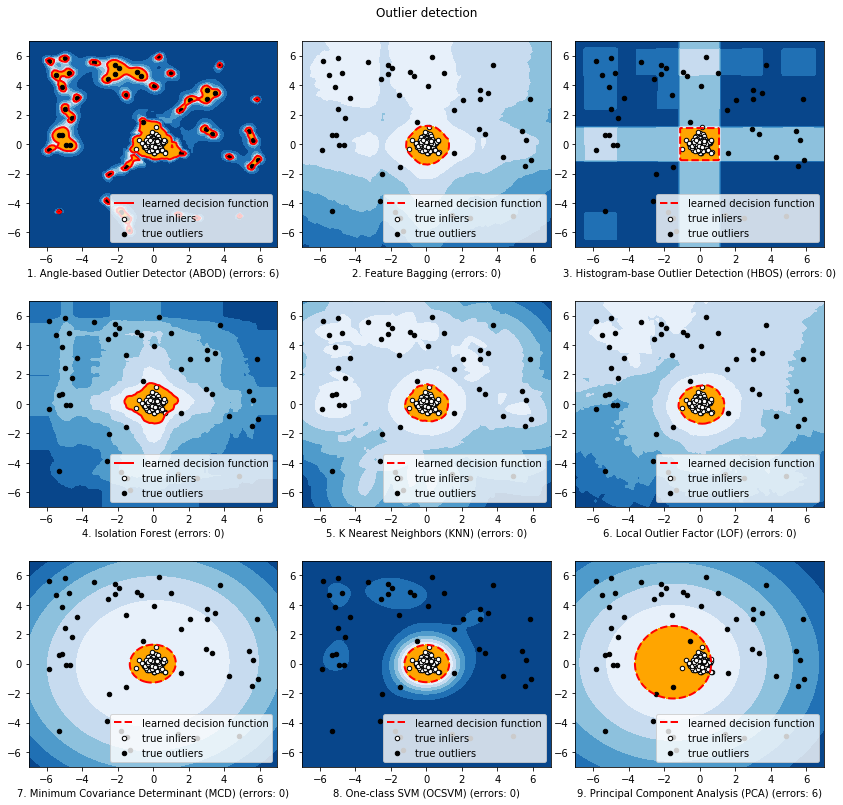

In [18]:
# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(12, 12))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 3, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.show()